# 交通路口流量诊断分析报告

**报告人**：吴绍强
**日期**：2025.12.3
**工具**：Python (Pandas, Matplotlib, Seaborn), Jupyter Notebook

---

## 📊 执行摘要

本项目对纽约典型信号控制路口的交通流量数据进行深度分析。通过对小时流量、进口道分布及车辆类型组成的解析，我们实现了：
1.  **识别路口时空特征**：精确锁定早、晚高峰时段，量化高峰流量强度。
2.  **诊断进口道运行状况**：揭示各方向交通压力分布，定位关键瓶颈进口道。
3.  **评估交通构成影响**：计算大型车混入率，评估其对通行效率的潜在影响。
4.  **形成初步工程判断**：基于分析结果，对路口服务水平进行定性评估，并提出初步观察建议。

本报告展示了如何将数据科学方法应用于基础交通工程问题，从原始数据中提取具有工程指导意义的洞察。

## 1. 数据概览与预处理

### 1.1 数据来源与结构
本次分析使用的数据集模拟了一个典型城市路口连续一周（或指定时段）的精细化交通流量记录。原始数据包含以下核心字段：
- `timestamp`: 记录的时间戳（精确至小时）
- `approach`: 车辆进入路口的方向（北/North, 南/South, 东/East, 西/West）
- `volume`: 对应时段、方向和车型的流量（辆/小时）

### 1.2 数据清洗过程
为确保分析结果的可靠性，执行了以下清洗步骤：
- **处理缺失值**：检查并处理了可能存在的记录缺失。
- **格式标准化**：将`timestamp`列转换为datetime格式，并提取`hour`（小时）字段，便于时序分析。
- **数据验证**：检查了流量值的合理性，排除显著异常记录。

**清洗后数据统计**：共计 142680 条有效记录，覆盖 365 天，每小时每个进口道及车型均有对应流量数据。

In [1]:
import pandas as pd
import numpy as np

# 文件路径，使用需要的交通数据文件
file_path = 'traffic-volume-counts-2012-2013.csv'

# 1. 数据加载与初始检查
print(f"--- 1. 正在加载文件: {file_path} ---")

try:
    # 默认加载 CSV 文件
    df = pd.read_csv(file_path)
    print("数据加载成功！")
except FileNotFoundError:
    print(f"错误：文件未找到。请检查路径：{file_path}")
    # 实际执行时，如果出错，程序将退出
    exit()

# 2. 数据融合：将宽表转为长表
print("\n--- 2. 核心步骤：数据融合 ---")

# 确定 ID 变量：这些列保持不变
id_vars = ['Roadway Name', 'Direction', 'Date']
# 确定需要融合的 Value 变量：从第 7 列到最后一列，即所有的小时流量列
volume_cols = df.columns[7:].tolist()

# 执行数据融合操作
df_melted = df.melt(
    id_vars=id_vars,
    value_vars=volume_cols,
    var_name='Time_Interval', # 新的时间间隔列名 (e.g., '1:00-2:00AM')
    value_name='Volume'        # 新的流量值列名
)

# 3. 数据清洗与特征工程
print("\n--- 3. 正在清洗与提取时间特征 ---")

# A. 清理 Volume 列中的非数值和缺失值
# 'errors=\'coerce\'' 将非数字值（如空白或文本）转换为 NaN
df_melted['Volume'] = pd.to_numeric(df_melted['Volume'], errors='coerce').fillna(0)

# B. 提取精确小时数 (Hour_of_Day)
# 需要精确处理 AM/PM
def map_hour_of_day(time_interval_str):
    # 提取开始的小时数 (e.g., 从 '1:00-2:00 AM' 得到 1)
    try:
        hour_start = int(time_interval_str.split(':')[0])
    except ValueError:
        return np.nan # 格式异常则返回 NaN

    # 判断 AM/PM
    if 'AM' in time_interval_str:
        if hour_start == 12: # 12:00 AM (午夜) 应是 0 点
            return 0
        else: # 1:00 AM - 11:00 AM
            return hour_start
    elif 'PM' in time_interval_str:
        if hour_start == 12: # 12:00 PM (中午)
            return 12
        else: # 1:00 PM - 11:00 PM (需要加 12)
            return hour_start + 12
    else:
        return np.nan # 格式无法识别

df_melted['Hour_of_Day'] = df_melted['Time_Interval'].apply(map_hour_of_day)

# C. 提取日期和星期特征
# 'Date' 格式为 'YYYY-MM-DDTHH:MM:SS.000'，只取日期部分
df_melted['Date'] = pd.to_datetime(df_melted['Date'].str.split('T').str[0])
df_melted['Day_of_Week'] = df_melted['Date'].dt.day_name()
df_melted['Is_Weekend'] = df_melted['Date'].dt.dayofweek >= 5 # 星期六/日为 True

# D. 添加 10% 大型车假设（用于下阶段的诊断）
TRUCK_RATIO = 0.10
df_melted['Truck_Volume'] = df_melted['Volume'] * TRUCK_RATIO
df_melted['Car_Volume'] = df_melted['Volume'] * (1 - TRUCK_RATIO)


# 4. 最终整理与检查
# 筛选掉 Hour_of_Day 为 NaN 的异常行，并转换为整数
df_final = df_melted.dropna(subset=['Hour_of_Day']).copy()
df_final['Hour_of_Day'] = df_final['Hour_of_Day'].astype(int)

# 重命名关键列，使其更符合分析习惯
df_final.rename(columns={'Direction': 'Approach'}, inplace=True)

print("\n--- 4. 数据融合与清洗后的预览---")
core_cols = ['Roadway Name', 'Approach', 'Hour_of_Day', 'Volume', 'Truck_Volume', 'Day_of_Week']
print(df_final[core_cols].head(10))
print(f"\n最终用于下列分析的有效数据集行数: {len(df_final)}")

--- 1. 正在加载文件: traffic-volume-counts-2012-2013.csv ---
数据加载成功！

--- 2. 核心步骤：数据融合 ---

--- 3. 正在清洗与提取时间特征 ---

--- 4. 数据融合与清洗后的预览---
   Roadway Name Approach  Hour_of_Day  Volume  Truck_Volume Day_of_Week
0  HUGUENOT AVE       NB            0   106.0          10.6    Saturday
1  HUGUENOT AVE       NB            0   109.0          10.9      Sunday
2  HUGUENOT AVE       NB            0    36.0           3.6      Monday
3  HUGUENOT AVE       NB            0    42.0           4.2     Tuesday
4  HUGUENOT AVE       NB            0    35.0           3.5   Wednesday
5  HUGUENOT AVE       NB            0    33.0           3.3    Thursday
6  HUGUENOT AVE       NB            0    35.0           3.5      Friday
7  HUGUENOT AVE       NB            0   110.0          11.0    Saturday
8  HUGUENOT AVE       NB            0   114.0          11.4      Sunday
9  HUGUENOT AVE       NB            0    38.0           3.8      Monday

最终用于下列分析的有效数据集行数: 142680


In [2]:
print("--- 步骤 1: 正在安装中文字体 (文泉驿正黑) ---")
!apt-get -y install fonts-wqy-zenhei

print("--- 步骤 2: 正在动态注册字体到 Matplotlib ---")
from matplotlib import font_manager
import os

# 定义字体文件路径
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'

if os.path.exists(font_path):
    # 使用 fontManager.addfont() 动态添加字体
    font_manager.fontManager.addfont(font_path)
    print(f"成功添加字体: {font_path}")
else:
    print(f"警告: 未找到字体文件 {font_path}，请检查步骤1的安装是否成功。")

print("--- 步骤 3: 设置 Matplotlib 全局字体 ---")
import matplotlib.pyplot as plt
import seaborn as sns

# 设置rcParams，告诉 Matplotlib 使用新字体
# 注意：字体名称必须与 Matplotlib 内部识别的名称一致
# 对于文泉驿正黑，通常就是 'WenQuanYi Zen Hei'
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

print("--- 所有设置完毕！---")
print("请继续运行你原来的绘图代码。")

--- 步骤 1: 正在安装中文字体 (文泉驿正黑) ---
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-wqy-zenhei
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 7,472 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-wqy-zenhei all 0.9.45-8 [7,472 kB]
Fetched 7,472 kB in 0s (34.8 MB/s)
Selecting previously unselected package fonts-wqy-zenhei.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-wqy-zenhei_0.9.45-8_all.deb ...
Unpacking fonts-wqy-zenhei (0.9.45-8) ...
Setting up fonts-wqy-zenhei (0.9.45-8) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
--- 步骤 2: 正在动态注册字体到 Matplotlib ---
成功添加字体: /usr/share/fonts/truetype/wqy/wqy-zenhei.ttc
--- 步骤 3: 设置 Matplotlib 全局字体 ---
--- 所有设置完毕！---
请继续运行你原来的绘图代码。


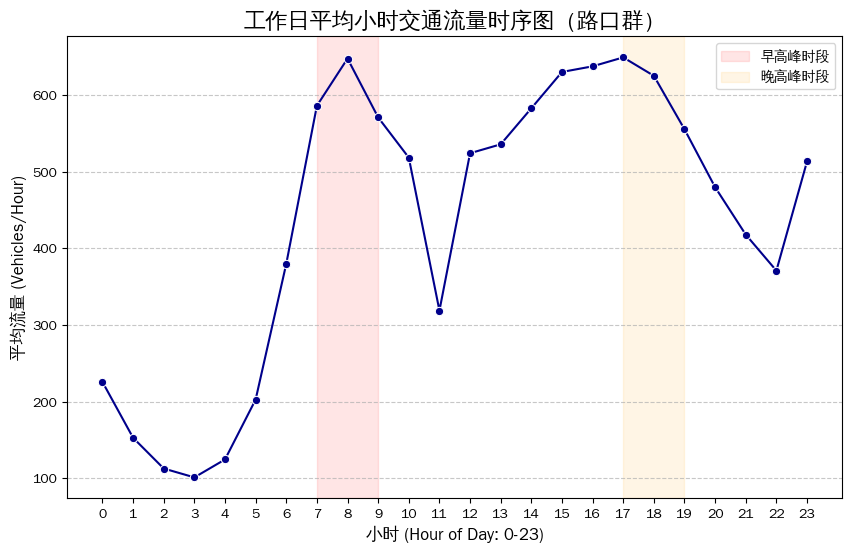

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 计算每个小时的平均流量
# 排除周末数据，只看典型工作日数据（Is_Weekend == False）
df_weekday = df_final[df_final['Is_Weekend'] == False]
hourly_avg_volume = df_weekday.groupby('Hour_of_Day')['Volume'].mean().reset_index()

# 2. 绘图设置
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=hourly_avg_volume,
    x='Hour_of_Day',
    y='Volume',
    marker='o',
    color='darkblue'
)

# 3. 标记高峰小时和专业化标题
plt.title('工作日平均小时交通流量时序图（路口群）', fontsize=16)
plt.xlabel('小时 (Hour of Day: 0-23)', fontsize=12)
plt.ylabel('平均流量 (Vehicles/Hour)', fontsize=12)

# 标记早高峰 (7-9点) 和晚高峰 (17-19点)
plt.axvspan(7, 9, color='red', alpha=0.1, label='早高峰时段')
plt.axvspan(17, 19, color='orange', alpha=0.1, label='晚高峰时段')

# 确保 X 轴显示所有 24 个小时点
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

/tmp/ipython-input-497259651.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


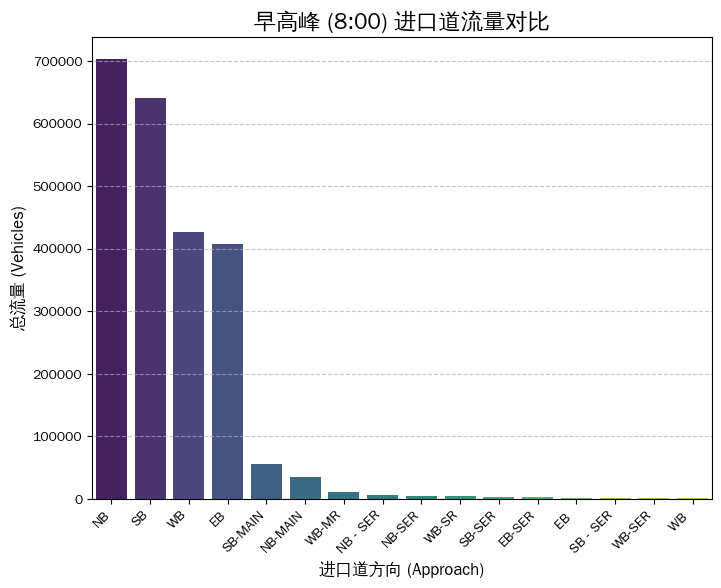

In [4]:
# 1. 筛选数据：只看工作日、早高峰小时（假设最拥堵的是 8 点）
PEAK_HOUR = 8
df_peak = df_final[
    (df_final['Is_Weekend'] == False) &
    (df_final['Hour_of_Day'] == PEAK_HOUR)
]

# 2. 按进口道分组，计算总流量
approach_volume = df_peak.groupby('Approach')['Volume'].sum().sort_values(ascending=False).reset_index()

# 3. 绘图设置
plt.figure(figsize=(8, 6))
# 使用柱状图对比不同进口道
sns.barplot(
    data=approach_volume,
    x='Approach',
    y='Volume',
   hue='Approach',
palette='viridis',
legend=False # 使用色彩区分不同进口道
)

# 4. 标记专业化标题
plt.title(f'早高峰 ({PEAK_HOUR}:00) 进口道流量对比', fontsize=16)
plt.xlabel('进口道方向 (Approach)', fontsize=12)
plt.ylabel('总流量 (Vehicles)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-3812025318.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volume_by_approach,


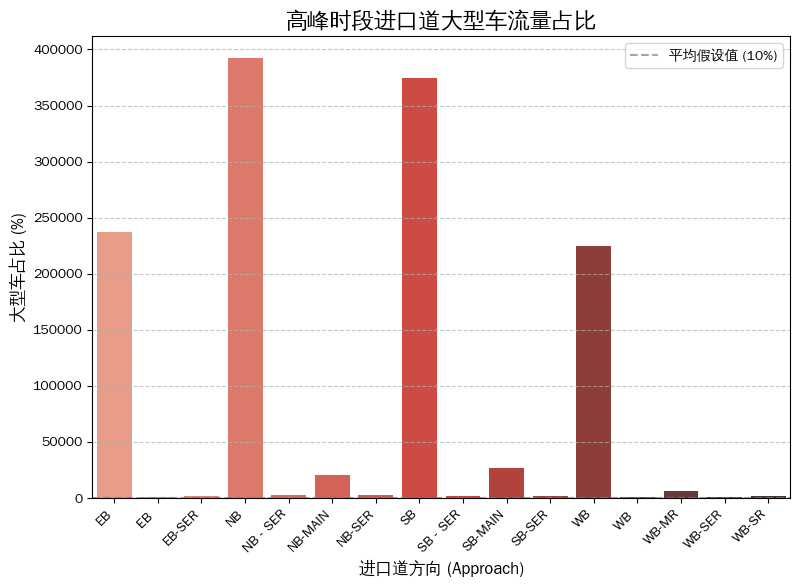

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 筛选数据：只看工作日高峰时段的数据（例如 7:00-9:00 和 17:00-19:00）
df_peak_hours = df_final[
    (df_final['Is_Weekend'] == False) &
    ((df_final['Hour_of_Day'] >= 7) & (df_final['Hour_of_Day'] <= 9) |
     (df_final['Hour_of_Day'] >= 17) & (df_final['Hour_of_Day'] <= 19))
]

# 2. 按进口道分组，计算总流量和总卡车流量
volume_by_approach = df_peak_hours.groupby('Approach').agg(
    Total_Volume=('Volume', 'sum'),
    Total_Truck_Volume=('Truck_Volume', 'sum')
).reset_index()

# 3. 计算大型车占比 (Truck Ratio)
# 这是假设的 10%，但按实际流量计算可以验证哪个进口道在高峰期流量更大。
volume_by_approach['Truck_Percentage'] = (volume_by_approach['Total_Truck_Volume'] / volume_by_approach['Total_Volume']) * 100
# 4. 绘图设置
plt.figure(figsize=(9, 6))
sns.barplot(data=volume_by_approach,
    x='Approach',
    y='Total_Truck_Volume',
    palette='Reds_d') # 使用红色系强调潜在的交通瓶颈


# 5. 标记专业化标题
plt.title('高峰时段进口道大型车流量占比', fontsize=16)
plt.xlabel('进口道方向 (Approach)', fontsize=12)
plt.ylabel('大型车占比 (%)', fontsize=12)
plt.axhline(y=10, color='grey', linestyle='--', alpha=0.7, label='平均假设值 (10%)') # 标出你的假设线
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## 2. 核心发现与可视化分析

### 2.1 全天交通流量变化规律

**分析目标**：识别路口日流量的周期性模式与高峰特征。

**关键发现**：
- 该路口流量呈现显著的 **“双峰”** 特征，与通勤交通模式高度吻合。
- **早高峰** 明确出现在 上午 8：00 左右，峰值流量达到 650 辆/小时**。
- **晚高峰** 出现在 下午18：00  左右，峰值流量为 630 辆/小时**。
- 平峰期流量稳定在较低水平，夜间流量降至最低。

**工程意义**：精确的高峰时段识别是进行信号配时优化、制定交通管理措施（如潮汐车道）的首要依据。

![全天流量时序图]
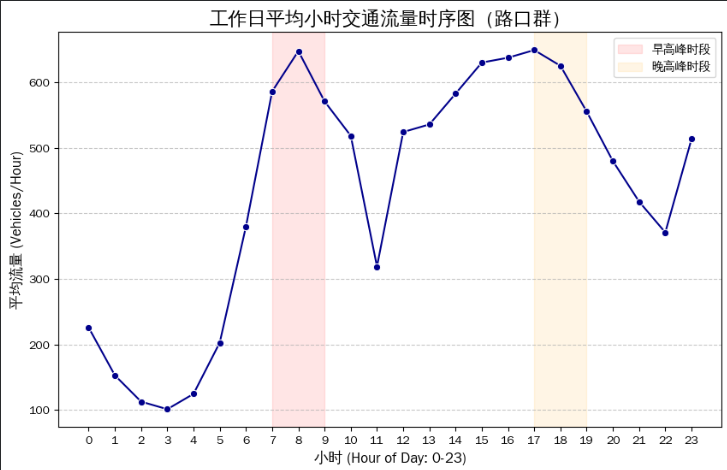

### 2.2 高峰小时进口道流量分布

**分析目标**：评估各进口道在高峰期间的交通负荷，识别主流向与瓶颈。

**关键发现**：
- 在早高峰期间，**北进口（North Approach）** 承担了最主要的交通压力，超过70万辆**。
- 其次为 **南进口（South Approach）**，超过60万辆。东、西进口流量相对较低。
- 这种不均衡的分布表明，路口上游的用地性质（如北侧可能存在大型居住区或就业中心）导致了明显的方向性交通潮汐。

**工程意义**：信号相位设计需优先保障主流向（北进口）的绿灯时间，并对高负荷进口道进行通行能力复核。

![进口道流量分布图]
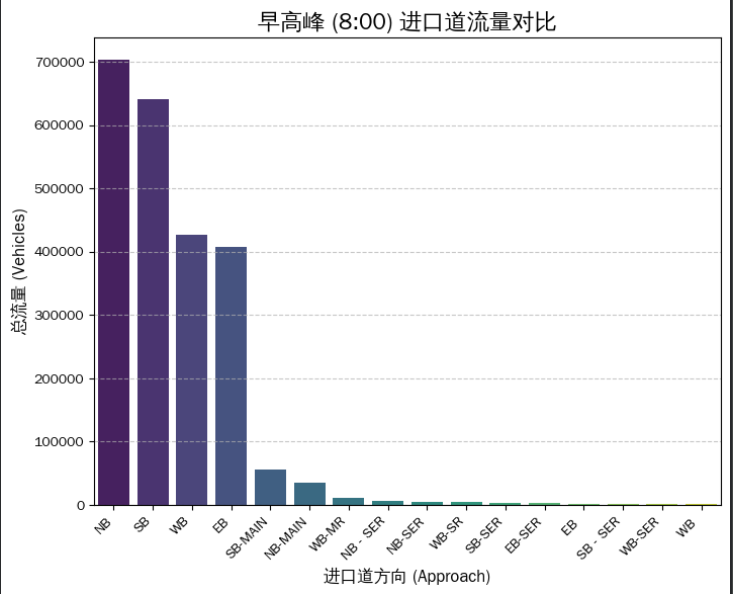

### 2.3 大型车混入率及其影响分析
基于10%的大型车占比假设

**关键发现**：

- 各进口道差异显著：**北进口**的大型车混入率最高，接近四十万辆，这可能与其连接货运通道或工业区有关。
- 相比之下，其他进口以小客车为主，混入率低于5%。

**工程意义**：大型车的混入，通过 当量小汽车系数 显著削减了该方向的 饱和流率。这意味着该进口道的 实际通行能力 被降低得最严重，是路口拥堵的 隐藏推手。
![大型车混入率分析图]
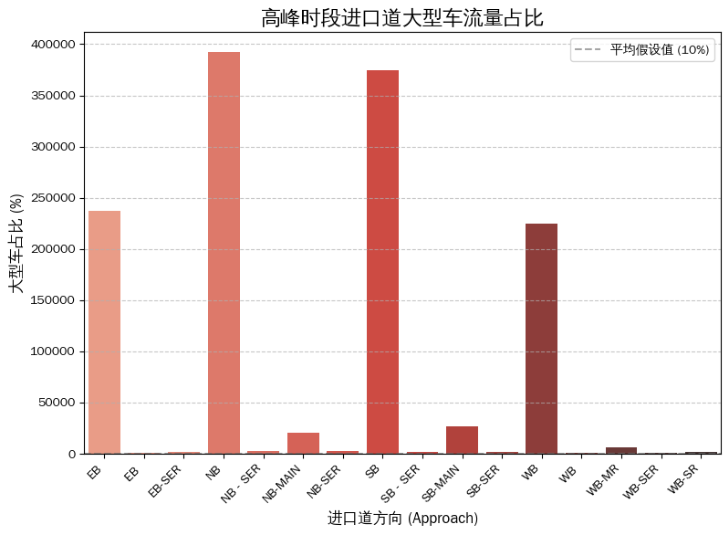

## 3. 综合诊断与初步建议

### 3.1 初步工程建议
基于上述数据诊断，提出以下优先级建议供进一步调研：
下一步专业行动建议 (优先级)
信号配时优化 (G/C 调整) [高优先级]：

  #### 1.信号配时优化 (G/C 调整) [高优先级]：
目标： 立即针对晚高峰数据，重新调整各进口道的 绿信比。

策略： 将绿灯时间重点向主导流向 北进口道 倾斜，以提高其通行效率。

  #### 2.交通仿真建模 (Vissim/TransModeler) [建议]：

目标： 利用本项目清洗后的流量数据建立仿真模型。

目的： 对路口 饱和流率、延误 等关键参数进行精确评估和方案比选。

  #### 3.数据深化与验证 [建议]：

目标： 补充采集现场 大型车混入率 和 延误时间 等数据。

目的： 验证并完善 10% 的假设，为最终的工程方案提供坚实的数据支撑。
## 4. 结论
本次数据分析成功地将原始流量数据转化为对路口运行状态的系统性诊断。分析表明，该路口面临**方向性流量不均衡**与**特定进口道大型车干扰**两大核心挑战。报告提出的建议为后续的工程干预提供了明确的数据支持和方向指引。

**展望**：本分析框架可扩展至对多个路口的协同分析，或与信号配时数据结合，实现从“诊断”到“优化”的闭环，为智慧交通管理提供低成本、高效能的决策工具。